# Ethereum Data Analysis with Apache Arrow Flight

This notebook demonstrates how to query Ethereum blockchain data using Apache Arrow Flight RPC and analyze it with Python data science tools.

## Prerequisites
- Flight RPC server running on `localhost:8815`
- Test data generated on Hardhat node

In [1]:
import pyarrow as pa
import pyarrow.flight as flight
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"PyArrow version: {pa.__version__}")
print(f"Pandas version: {pd.__version__}")

PyArrow version: 13.0.0
Pandas version: 2.1.1


## 1. Connect to Flight RPC Server

In [2]:
# Connect to the Flight server
client = flight.connect('grpc://flight-server:8815')
print("✅ Connected to Flight RPC server")

✅ Connected to Flight RPC server


## 2. Query Ethereum Logs

Let's fetch all historical logs from the blockchain.

In [3]:
# Define query for logs (all historical data)
logs_request = {
    "dataset": "logs",
    "startBlock": "0",
    "endBlock": "100"  # Fetch first 1000 blocks
}

# Create ticket
ticket = flight.Ticket(json.dumps(logs_request).encode('utf-8'))

# Fetch data stream
print("Fetching logs...")
reader = client.do_get(ticket)

# Read all batches into a single table
logs_table = reader.read_all()

print(f"✅ Fetched {logs_table.num_rows} log entries")
print(f"Schema: {logs_table.schema}")

Fetching logs...
✅ Fetched 50 log entries
Schema: address: string
data: string
topics: list<topic: string>
  child 0, topic: string
blockNumber: int64
transactionHash: string
transactionIndex: int32
blockHash: string
logIndex: int32
removed: bool


## 3. Convert to Pandas for Analysis

In [4]:
# Zero-copy conversion to pandas
logs_df = logs_table.to_pandas()

print(f"DataFrame shape: {logs_df.shape}")
print(f"\nColumns: {list(logs_df.columns)}")
print(f"\nFirst few rows:")
logs_df.head()

DataFrame shape: (50, 9)

Columns: ['address', 'data', 'topics', 'blockNumber', 'transactionHash', 'transactionIndex', 'blockHash', 'logIndex', 'removed']

First few rows:


,address,data,topics,blockNumber,transactionHash,transactionIndex,blockHash,logIndex,removed
0,0x5fbdb2315678afecb367f032d93f642f64180aa3,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,2,0x879bd97698662788e80818f923d387551c8dbbc99eb6...,0,0x196b9bdc7a9c92c6abafe5bd4bd7434689ec06b1d570...,0,False
1,0x5fbdb2315678afecb367f032d93f642f64180aa3,0x00000000000000000000000000000000000000000000...,[0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b...,3,0xfba9545e4603f85ca5a7d174e96682722a5c5cc2f4a2...,0,0x69e21fcf436b06cc17bbbdebe7001af02dca2d811b39...,0,False
2,0x5fbdb2315678afecb367f032d93f642f64180aa3,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,4,0xdc9c18a311e5d0e9c8263366e262dc535b42a87383b6...,0,0xfab5cf7108d8c34d872f4c5e278e0633c3451ee70036...,0,False
3,0x5fbdb2315678afecb367f032d93f642f64180aa3,0x00000000000000000000000000000000000000000000...,[0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b...,5,0x46bd29e9fb64b0b9fc1b11edf6c1e10b88c5762a6586...,0,0x5e775455890bc2f268a01e85897d1ed283e43e92a024...,0,False
4,0x5fbdb2315678afecb367f032d93f642f64180aa3,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,6,0xe6c8b3b8e541455fb60ce26fb213c5afb04a8f8955ef...,0,0x017c5fe3507a0899f0452412a7ad5811aa03ac3fba39...,0,False


In [5]:
# Basic statistics
print("Dataset Info:")
print(f"Total logs: {len(logs_df)}")
print(f"Unique addresses: {logs_df['address'].nunique()}")
print(f"Block range: {logs_df['blockNumber'].min()} - {logs_df['blockNumber'].max()}")
print(f"Removed logs: {logs_df['removed'].sum()}")

Dataset Info:
Total logs: 50
Unique addresses: 1
Block range: 2 - 51
Removed logs: 0


## 4. Analyze Event Signatures

Extract the first topic (event signature) from each log.

In [ ]:
# Extract first topic (event signature)
logs_df['event_signature'] = logs_df['topics'].apply(lambda x: x[0] if len(x) > 0 else None)

# Count events by signature
event_counts = logs_df['event_signature'].value_counts()

print("Event distribution:")
print(event_counts)

# Known event signatures (Keccak-256 hashes)
EVENT_SIGNATURES = {
    '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef': 'Transfer',
    '0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925': 'Approval'
}

logs_df['event_name'] = logs_df['event_signature'].map(EVENT_SIGNATURES).fillna('Unknown')
print("\nEvent names:")
print(logs_df['event_name'].value_counts())

## 5. Visualize Event Distribution

In [ ]:
# Plot event distribution
plt.figure(figsize=(10, 6))
event_name_counts = logs_df['event_name'].value_counts()
event_name_counts.plot(kind='bar', color='steelblue')
plt.title('Event Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Event Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Analyze Logs by Block

In [ ]:
# Group logs by block
logs_per_block = logs_df.groupby('blockNumber').size()

plt.figure(figsize=(12, 6))
logs_per_block.plot(kind='line', marker='o', markersize=3, linewidth=1)
plt.title('Logs per Block Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Block Number', fontsize=12)
plt.ylabel('Number of Logs', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average logs per block: {logs_per_block.mean():.2f}")
print(f"Max logs in a single block: {logs_per_block.max()}")

## 7. Query Blocks Data

In [11]:
# Query blocks
blocks_request = {
    "dataset": "blocks",
    "startBlock": "0",
    "endBlock": "50"
}

ticket = flight.Ticket(json.dumps(blocks_request).encode('utf-8'))
print("Fetching blocks...")
reader = client.do_get(ticket)
blocks_table = reader.read_all()

print(f"✅ Fetched {blocks_table.num_rows} blocks")

# Convert to pandas
blocks_df = blocks_table.to_pandas()
blocks_df.head()

Fetching blocks...
✅ Fetched 51 blocks


,number,hash,parentHash,timestamp,author,miner,transactionsRoot,stateRoot,receiptsRoot,logsBloom,...,size,extraData,nonce,difficulty,totalDifficulty,mixHash,sha3Uncles,transactions,uncles,sealFields
0,0,0xe711e3e3dfc3466b6b82f71403f5ca1350b264280153...,0x00000000000000000000000000000000000000000000...,1769452164,None,0x0000000000000000000000000000000000000000,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x950cc3b1c26a9cd52a81793977d91eb11603c3103752...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x00000000000000000000000000000000000000000000...,...,512,0x1234,0x0000000000000000,0x0,0x0,0x53c5ae3ce8eefbfad3aca77e5f4e1b19a949b04e2e5c...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,[],[],None
1,1,0x358d812503bc632b6954757e40ddc33dfeb760cf976b...,0xe711e3e3dfc3466b6b82f71403f5ca1350b264280153...,1769452171,None,0xc014ba5ec014ba5ec014ba5ec014ba5ec014ba5e,0x538cd25642f1a38b21d4ce2cc69aa758001db680e5fd...,0x1b1c5fe584c005fb51e365609f6f65a90f65e9ea6941...,0x9e4b83edb34f4454ceec6251aee7a1949060ff11ec6f...,0x00000000000000000000000000000000000000000000...,...,969,0x,0x0000000000000000,0x0,0x0,0xf4fbfa6c8463f342eb58838d8c6b0661faf22e7076a5...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,[0x775d2c7275c92d39f8b5341c73bb5458ccb53388e4a...,[],None
2,2,0x196b9bdc7a9c92c6abafe5bd4bd7434689ec06b1d570...,0x358d812503bc632b6954757e40ddc33dfeb760cf976b...,1769452172,None,0xc014ba5ec014ba5ec014ba5ec014ba5ec014ba5e,0xc565be1cced525e548176b7cae69c582656b95108a66...,0x1c921074fec6c746282ece97e9aef01782f15afd5fed...,0x2f30bc695c18ad342c1728023ae0283f91c852bf54cc...,0x00000000000000000002000000000000000000000000...,...,681,0x,0x0000000000000000,0x0,0x0,0x36e0e2ad178d961006334c968a7f38fc9e049070a61e...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,[0x879bd97698662788e80818f923d387551c8dbbc99eb...,[],None
3,3,0x69e21fcf436b06cc17bbbdebe7001af02dca2d811b39...,0x196b9bdc7a9c92c6abafe5bd4bd7434689ec06b1d570...,1769452173,None,0xc014ba5ec014ba5ec014ba5ec014ba5ec014ba5e,0x7bae150761b1475ed0720beb84592e43b408eff6fd00...,0xcabf5764bb2ad7f186f7e2a3ec04ccd93236b623898d...,0xf11163654ab04601bfcaf4447978321abc758dce9b97...,0x00000000000000000002000000000000000000000000...,...,681,0x,0x0000000000000000,0x0,0x0,0x941e24315e7def23adef19eaa877e897ff000a831456...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,[0xfba9545e4603f85ca5a7d174e96682722a5c5cc2f4a...,[],None
4,4,0xfab5cf7108d8c34d872f4c5e278e0633c3451ee70036...,0x69e21fcf436b06cc17bbbdebe7001af02dca2d811b39...,1769452174,None,0xc014ba5ec014ba5ec014ba5ec014ba5ec014ba5e,0x1a75e2c8d7d990981cffea0dbec6af76d753e091c8c9...,0xac01df28a8e13f13087fb9e6138768e2bb824d6c5460...,0x1ba80346994cba074111ce11b1c2568546c3b5c11b2a...,0x00000000000000000002000000000000000000000000...,...,681,0x,0x0000000000000000,0x0,0x0,0x49336c43860098c947677fdfe0fc5c42093ed7f2ec6c...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,[0xdc9c18a311e5d0e9c8263366e262dc535b42a87383b...,[],None


## 8. Analyze Block Gas Usage

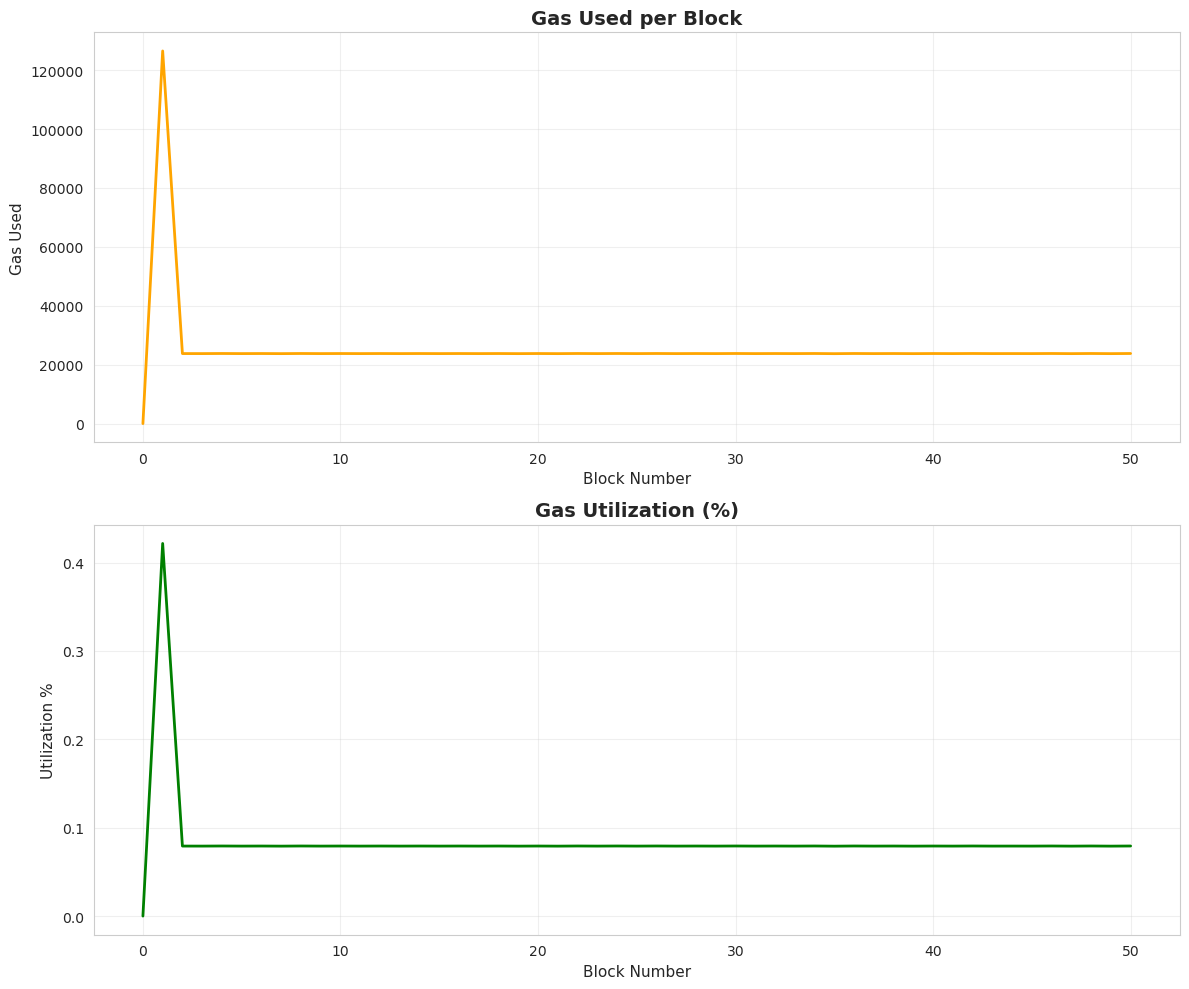

Average gas utilization: 0.08%
Max gas utilization: 0.42%


In [12]:
# Calculate gas utilization percentage
blocks_df['gas_utilization'] = (blocks_df['gasUsed'] / blocks_df['gasLimit']) * 100

# Plot gas usage over time
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Gas used
axes[0].plot(blocks_df['number'], blocks_df['gasUsed'], color='orange', linewidth=2)
axes[0].set_title('Gas Used per Block', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Block Number', fontsize=11)
axes[0].set_ylabel('Gas Used', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Gas utilization percentage
axes[1].plot(blocks_df['number'], blocks_df['gas_utilization'], color='green', linewidth=2)
axes[1].set_title('Gas Utilization (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Block Number', fontsize=11)
axes[1].set_ylabel('Utilization %', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average gas utilization: {blocks_df['gas_utilization'].mean():.2f}%")
print(f"Max gas utilization: {blocks_df['gas_utilization'].max():.2f}%")

## 9. Analyze Transaction Count

/tmp/ipykernel_102/2106260558.py:2: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  blocks_df['tx_count'] = blocks_df['transactions'].apply(lambda x: len(x) if x else 0)


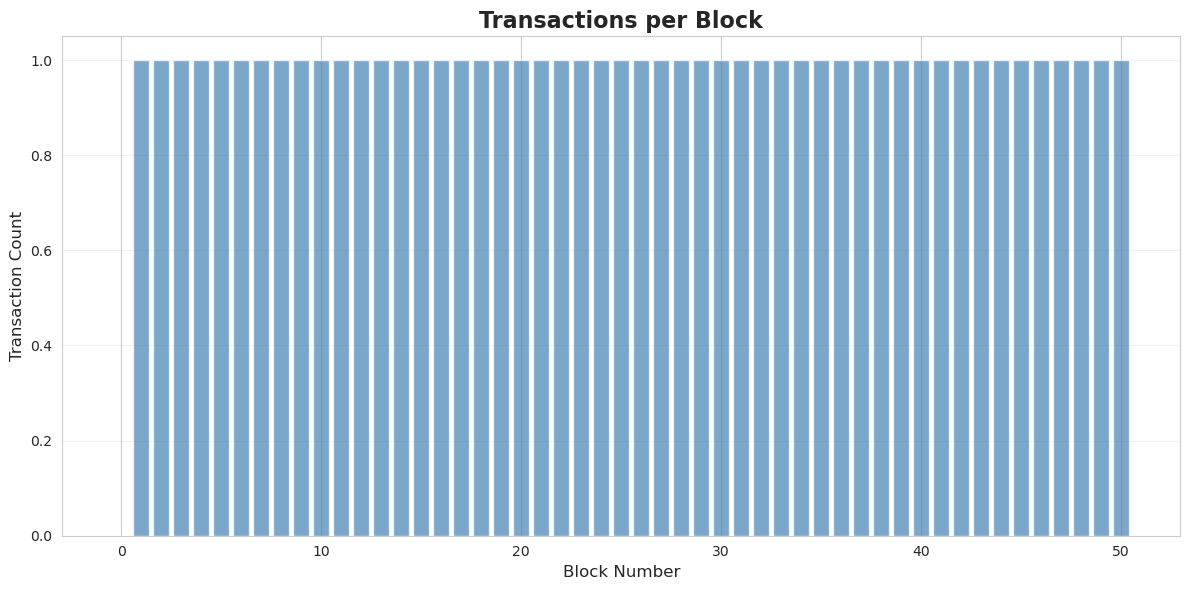

Total transactions: 50
Average transactions per block: 0.98
Blocks with transactions: 50


In [13]:
# Count transactions per block
blocks_df['tx_count'] = blocks_df['transactions'].apply(lambda x: len(x) if x else 0)

plt.figure(figsize=(12, 6))
plt.bar(blocks_df['number'], blocks_df['tx_count'], color='steelblue', alpha=0.7)
plt.title('Transactions per Block', fontsize=16, fontweight='bold')
plt.xlabel('Block Number', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Total transactions: {blocks_df['tx_count'].sum()}")
print(f"Average transactions per block: {blocks_df['tx_count'].mean():.2f}")
print(f"Blocks with transactions: {(blocks_df['tx_count'] > 0).sum()}")

## 10. Join Logs and Blocks for Combined Analysis

In [14]:
# Join logs with block data
combined_df = logs_df.merge(
    blocks_df[['number', 'timestamp', 'gasUsed', 'gasLimit']], 
    left_on='blockNumber', 
    right_on='number',
    how='left'
)

# Convert timestamp to datetime
combined_df['datetime'] = pd.to_datetime(combined_df['timestamp'], unit='s')

print(f"Combined dataset shape: {combined_df.shape}")
combined_df[['blockNumber', 'event_name', 'gasUsed', 'datetime']].head(10)

Combined dataset shape: (50, 16)


,blockNumber,event_name,gasUsed,datetime
0,2,Transfer,23772.0,2026-01-26 18:29:32
1,3,Approval,23763.0,2026-01-26 18:29:33
2,4,Transfer,23796.0,2026-01-26 18:29:34
3,5,Approval,23763.0,2026-01-26 18:29:35
4,6,Transfer,23784.0,2026-01-26 18:29:36
5,7,Approval,23751.0,2026-01-26 18:29:37
6,8,Transfer,23796.0,2026-01-26 18:29:38
7,9,Approval,23763.0,2026-01-26 18:29:39
8,10,Transfer,23784.0,2026-01-26 18:29:40
9,11,Approval,23763.0,2026-01-26 18:29:41


## 11. Summary Statistics

In [15]:
print("="*60)
print("ETHEREUM DATA ANALYSIS SUMMARY")
print("="*60)
print(f"\n📊 Logs Dataset:")
print(f"   Total logs: {len(logs_df):,}")
print(f"   Unique contracts: {logs_df['address'].nunique()}")
print(f"   Block range: {logs_df['blockNumber'].min()} - {logs_df['blockNumber'].max()}")
print(f"   Event types: {logs_df['event_name'].nunique()}")

print(f"\n⛓️  Blocks Dataset:")
print(f"   Total blocks: {len(blocks_df):,}")
print(f"   Total transactions: {blocks_df['tx_count'].sum():,}")
print(f"   Avg gas utilization: {blocks_df['gas_utilization'].mean():.2f}%")
print(f"   Avg block size: {blocks_df['size'].mean():,.0f} bytes")

print(f"\n🔗 Most Active Contract:")
top_contract = logs_df['address'].value_counts().iloc[0]
top_contract_addr = logs_df['address'].value_counts().index[0]
print(f"   Address: {top_contract_addr}")
print(f"   Log count: {top_contract:,}")

print("\n" + "="*60)

ETHEREUM DATA ANALYSIS SUMMARY

📊 Logs Dataset:
   Total logs: 50
   Unique contracts: 1
   Block range: 2 - 51
   Event types: 2

⛓️  Blocks Dataset:
   Total blocks: 51
   Total transactions: 50
   Avg gas utilization: 0.08%
   Avg block size: 683 bytes

🔗 Most Active Contract:
   Address: 0x5fbdb2315678afecb367f032d93f642f64180aa3
   Log count: 50



## 12. Advanced: Filter Specific Contract Events

Now let's query only events from a specific contract address.

In [16]:
# Get the most active contract address
target_contract = logs_df['address'].value_counts().index[0]
print(f"Querying logs for contract: {target_contract}")

# Query with address filter
filtered_logs_request = {
    "dataset": "logs",
    "startBlock": "0",
    "endBlock": "1000",
    "contractAddresses": [target_contract]
}

ticket = flight.Ticket(json.dumps(filtered_logs_request).encode('utf-8'))
reader = client.do_get(ticket)
filtered_logs_table = reader.read_all()
filtered_logs_df = filtered_logs_table.to_pandas()

print(f"✅ Fetched {len(filtered_logs_df)} logs for this contract")
filtered_logs_df.head()

Querying logs for contract: 0x5fbdb2315678afecb367f032d93f642f64180aa3
✅ Fetched 52 logs for this contract


,address,data,topics,blockNumber,transactionHash,transactionIndex,blockHash,logIndex,removed
0,0x5fbdb2315678afecb367f032d93f642f64180aa3,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,2,0x879bd97698662788e80818f923d387551c8dbbc99eb6...,0,0x196b9bdc7a9c92c6abafe5bd4bd7434689ec06b1d570...,0,False
1,0x5fbdb2315678afecb367f032d93f642f64180aa3,0x00000000000000000000000000000000000000000000...,[0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b...,3,0xfba9545e4603f85ca5a7d174e96682722a5c5cc2f4a2...,0,0x69e21fcf436b06cc17bbbdebe7001af02dca2d811b39...,0,False
2,0x5fbdb2315678afecb367f032d93f642f64180aa3,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,4,0xdc9c18a311e5d0e9c8263366e262dc535b42a87383b6...,0,0xfab5cf7108d8c34d872f4c5e278e0633c3451ee70036...,0,False
3,0x5fbdb2315678afecb367f032d93f642f64180aa3,0x00000000000000000000000000000000000000000000...,[0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b...,5,0x46bd29e9fb64b0b9fc1b11edf6c1e10b88c5762a6586...,0,0x5e775455890bc2f268a01e85897d1ed283e43e92a024...,0,False
4,0x5fbdb2315678afecb367f032d93f642f64180aa3,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,6,0xe6c8b3b8e541455fb60ce26fb213c5afb04a8f8955ef...,0,0x017c5fe3507a0899f0452412a7ad5811aa03ac3fba39...,0,False


## Conclusion

This notebook demonstrated:
- ✅ Connecting to Apache Arrow Flight RPC server
- ✅ Querying Ethereum logs and blocks with zero-copy efficiency
- ✅ Converting to Pandas for analysis
- ✅ Visualizing blockchain data
- ✅ Filtering by contract address
- ✅ Joining multiple datasets

The Arrow Flight protocol provides:
- **Zero-copy data transfer** - no serialization overhead
- **Streaming support** - handle large datasets efficiently
- **Native integration** - works seamlessly with pandas, polars, datafusion, and more

Perfect for blockchain data engineering and analytics! 🚀